In [231]:
%pip install ucimlrepo
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [232]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
combined_cycle_power_plant = fetch_ucirepo(id=294) 
  
# data (as pandas dataframes) 
df = combined_cycle_power_plant.data.original
x_labels = combined_cycle_power_plant.data.feature_names
  
# metadata 
print(combined_cycle_power_plant.metadata) 
  
# variable information 
print(combined_cycle_power_plant.variables) 


{'uci_id': 294, 'name': 'Combined Cycle Power Plant', 'repository_url': 'https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant', 'data_url': 'https://archive.ics.uci.edu/static/public/294/data.csv', 'abstract': 'The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the plant was set to work with full load. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 9568, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['PE'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2014, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5002N', 'creators': ['Pnar Tfekci', 'Heysem Kaya'], 'intro_paper': {'title': 'Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods', 'authors': 'Pınar Tüfekci', 'publ

## Dataset Info

In [233]:
print(df.describe())

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000


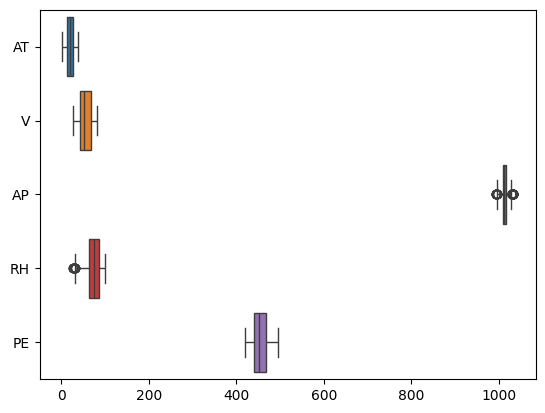

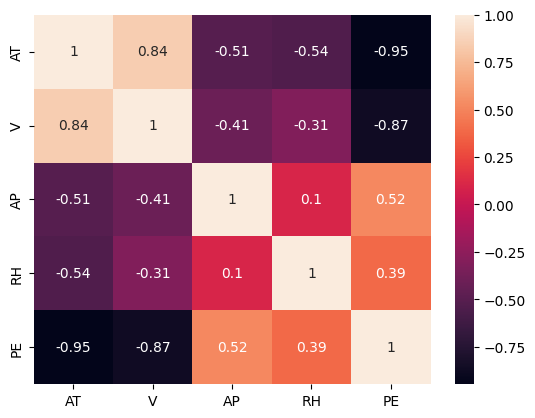

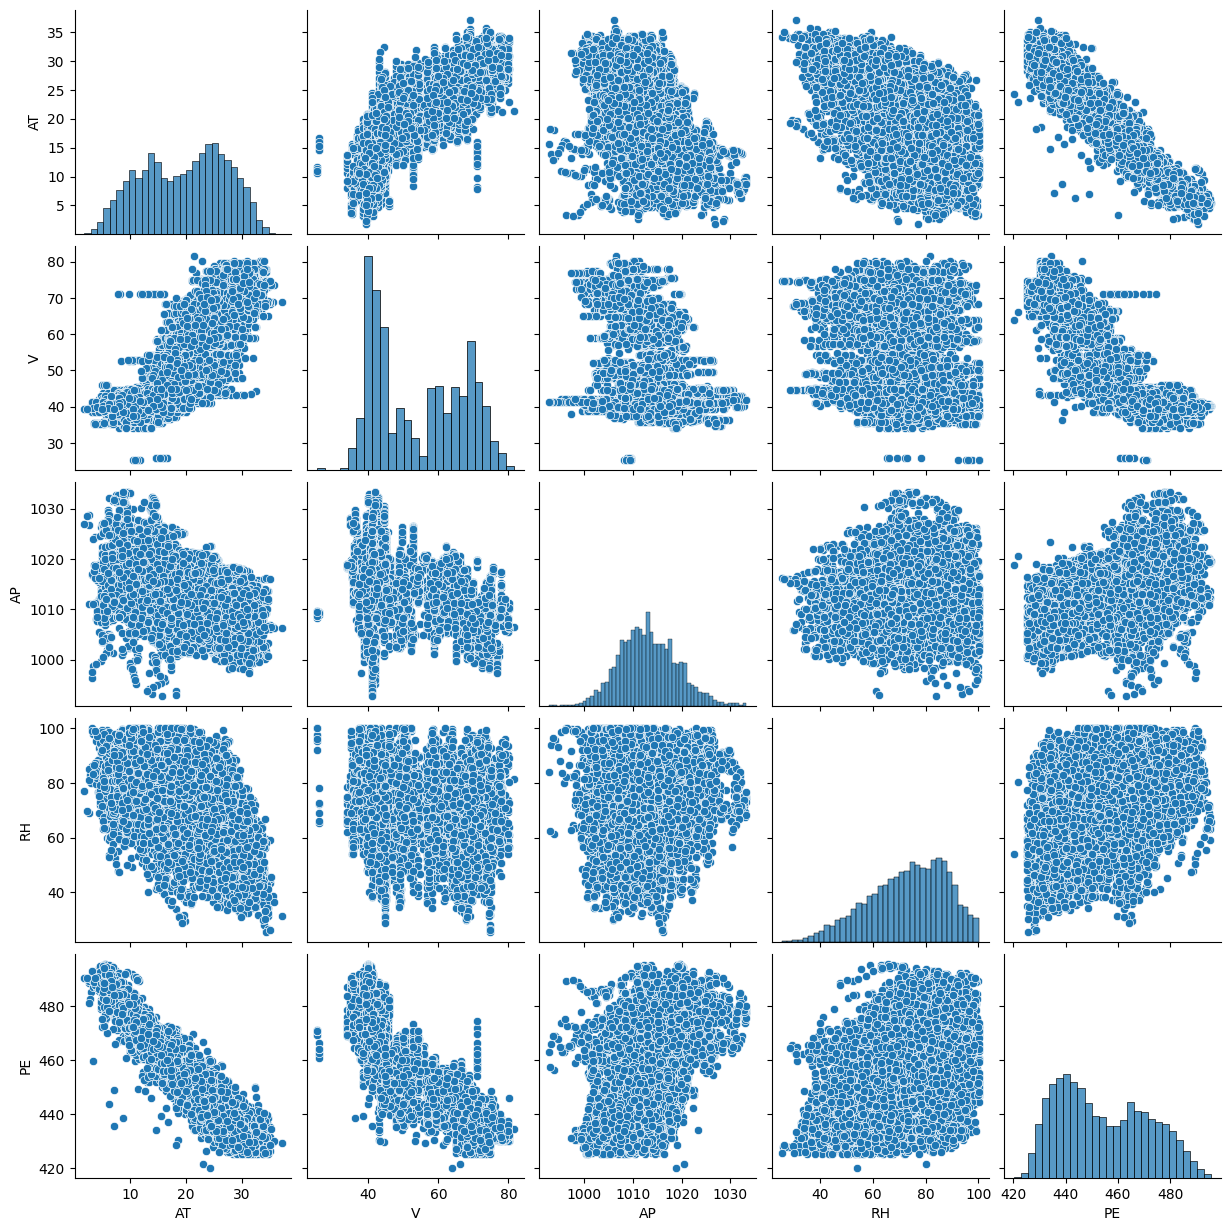

In [234]:
# visualize outliers
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(data = df, orient = 'h')
plt.show()

# visualize correlation
sns.heatmap(df.corr(), annot = True)
plt.show()

# pairplot
sns.pairplot(df)
plt.show()

In [235]:
# calculate VIF
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df)
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

  variables           VIF
0     const  53712.788414
1        AT     16.434722
2         V      4.368446
3        AP      1.459184
4        RH      1.961683
5        PE     14.024476


## Training Models

In [236]:
# helper functions
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import seaborn as sns

import joblib

# results stash
results = []

def trainPipelineModel(pipeline, model, x, y, test_size=0.4, random_state=42):
  pipeline.steps.append(('model', model))
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
  pipeline.fit(X_train, y_train)
  return pipeline, X_test, y_test

def displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label):
  y_pred = pipeline.predict(X_test)

  model = pipeline.named_steps['model']

  coef = model.coef_
  mean_se = mean_squared_error(y_test, y_pred)
  root_mean_se = root_mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print("Coefficients: \n", model.coef_)
  print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
  print("Root mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred))
  print("R2: %.2f" % r2_score(y_test, y_pred))

  # plot true values vs predictions
  plt.scatter(y_test, y_pred)
  plt.title(title + " - True Values vs Predictions")
  plt.xlabel("True Values")
  plt.ylabel("Predictions")
  plt.show()

  # plot residuals
  residuals = y_test - y_pred
  sns.displot(residuals, kde=True)
  plt.title(title + " - Residuals")
  plt.show()

  # assuming we have a multiple linear regression model
  # we can plot the regression line for each feature
  for i in range(len(x_labels)):
    # get column index
    column_index = X_test.columns.get_loc(x_labels[i])
    # plot regression line with low opacity points to visualize the spread
    sns.regplot(x=X_test.iloc[:, column_index], y=y_test, fit_reg=True, scatter_kws={'alpha':0.5})
    plt.gca().get_lines()[0].set_color('red')
    plt.xlabel(x_labels[i])
    plt.ylabel(y_label)
    plt.title(title + " - " + x_labels[i] + " vs " + y_label)
    plt.show()
    # sns.regplot(x=X_test.iloc[:, column_index], y=y_test, fit_reg=True)
    # plt.gca().get_lines()[0].set_color('red')
    # plt.xlabel(x_labels[i])
    # plt.ylabel(y_label)
    # plt.title(title + " - " + x_labels[i] + " vs " + y_label)
    # plt.show()

  return coef, mean_se, root_mean_se, r2

def stashResults(title, coef, mean_se, root_mean_se, r2):
  results.append({
    "title": title,
    "coef": coef,
    "mean_se": mean_se,
    "root_mean_se": root_mean_se,
    "r2": r2,
    "r2_percentage": r2 * 100
  })

def saveModel(pipeline, model_name):
  joblib.dump(pipeline, model_name)

def modelSanityCheck(joblib_dump, X_test, y_test):
  pipeline = joblib.load(joblib_dump)
  y_pred = pipeline.predict(X_test)
  print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
  print("Root mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred))
  print("R2: %.2f" % r2_score(y_test, y_pred))
  return pipeline

### Baseline

Coefficients: 
 [-14.79448866  -2.94049833   0.29904345  -2.37647951]
Mean squared error: 20.65
Root mean squared error: 4.54
R2: 0.93


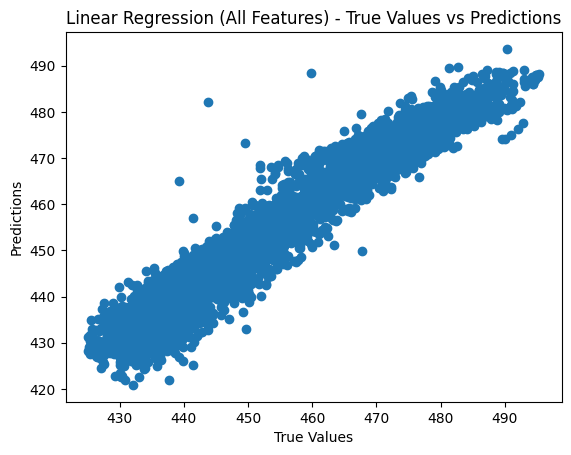

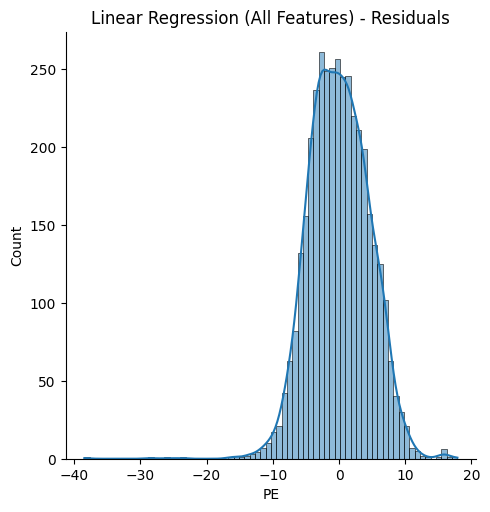

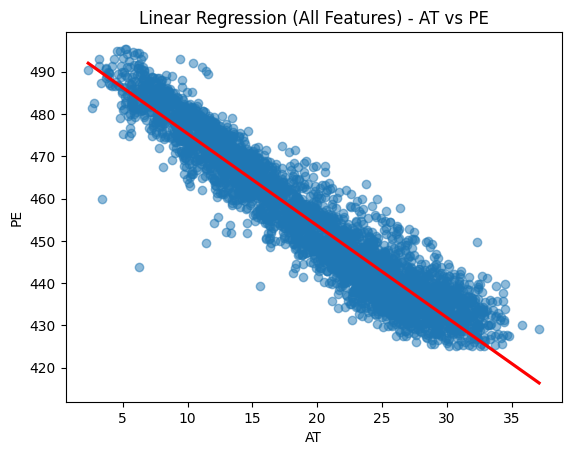

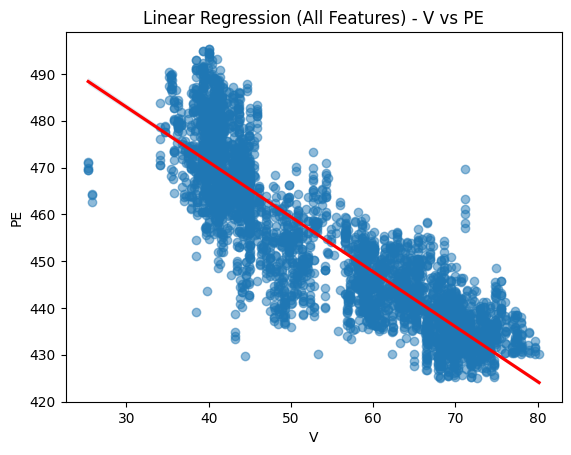

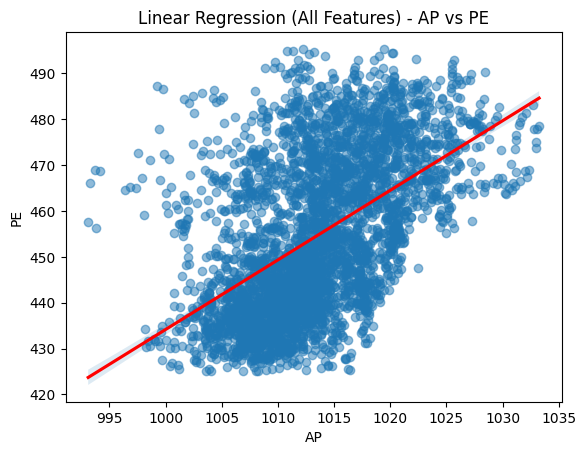

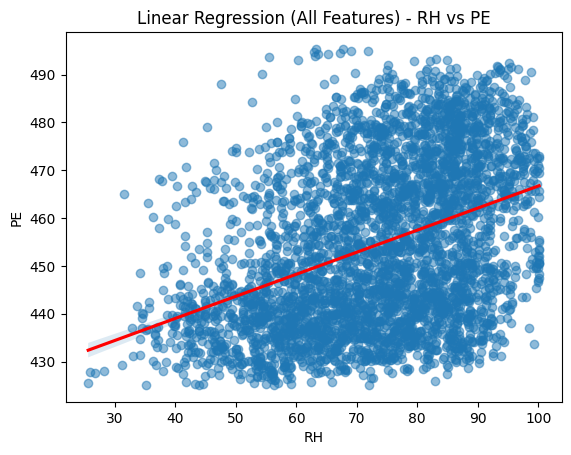

Mean squared error: 20.65
Root mean squared error: 4.54
R2: 0.93


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('model', LinearRegression())])

In [237]:
# linear regression using make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# all features
x_labels = ["AT", "V", "AP", "RH"]
y_label = "PE"
title = "Linear Regression (All Features)"

# get x set wherein we only get the required columns
x_set = df[x_labels]
y_set = df[y_label]

model = LinearRegression()
pipeline = make_pipeline(
    StandardScaler()
)

pipeline, X_test, y_test = trainPipelineModel(pipeline, model, x_set, y_set)
coef, mean_se, root_mean_se, r2 = displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label)
stashResults(title, coef, mean_se, root_mean_se, r2)
saveModel(pipeline, "linear_regression_all_features.pkl")
modelSanityCheck("linear_regression_all_features.pkl", X_test, y_test)

### AP, RH only

Coefficients: 
 [8.09861511 5.70311613]
Mean squared error: 176.88
Root mean squared error: 13.30
R2: 0.40


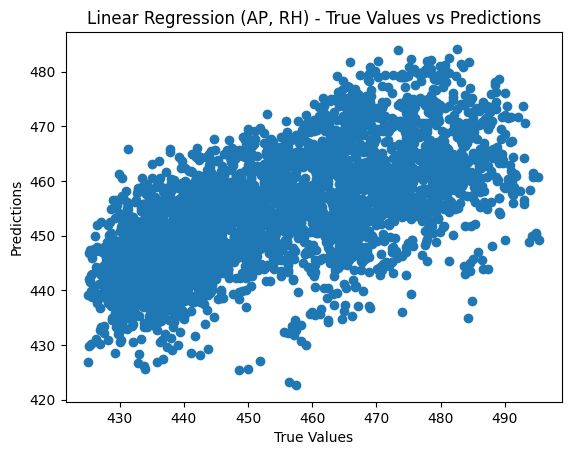

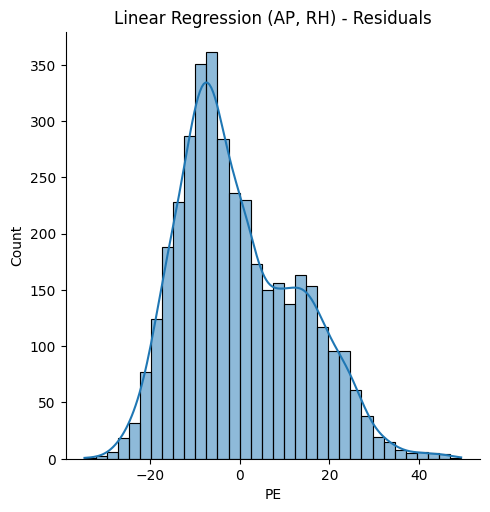

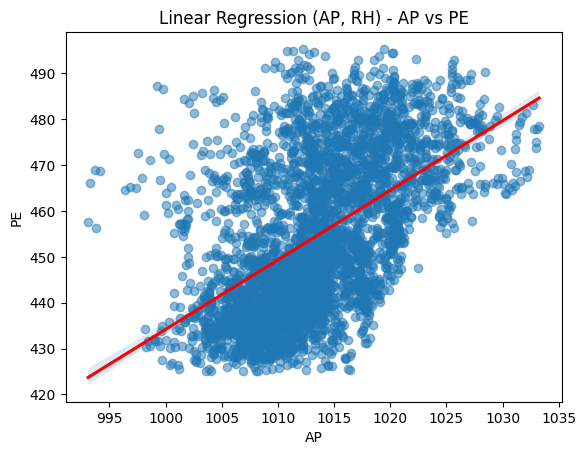

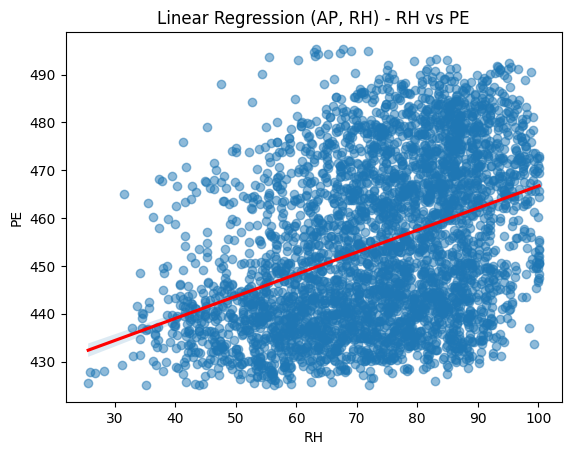

Mean squared error: 176.88
Root mean squared error: 13.30
R2: 0.40


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('model', LinearRegression())])

In [238]:
# linear regression using make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler

# all features
x_labels = ["AP", "RH"]
y_label = "PE"
title = "Linear Regression (AP, RH)"

# get x set wherein we only get the required columns
x_set = df[x_labels]
y_set = df[y_label]

model = LinearRegression()
pipeline = make_pipeline(
    StandardScaler()
)

pipeline, X_test, y_test = trainPipelineModel(pipeline, model, x_set, y_set)
coef, mean_se, root_mean_se, r2 = displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label)
stashResults(title, coef, mean_se, root_mean_se, r2)
saveModel(pipeline, "linear_regression_AP_RH.pkl")
modelSanityCheck("linear_regression_AP_RH.pkl", X_test, y_test)

### AT, V only

Coefficients: 
 [-12.63037886  -4.1537008 ]
Mean squared error: 24.33
Root mean squared error: 4.93
R2: 0.92


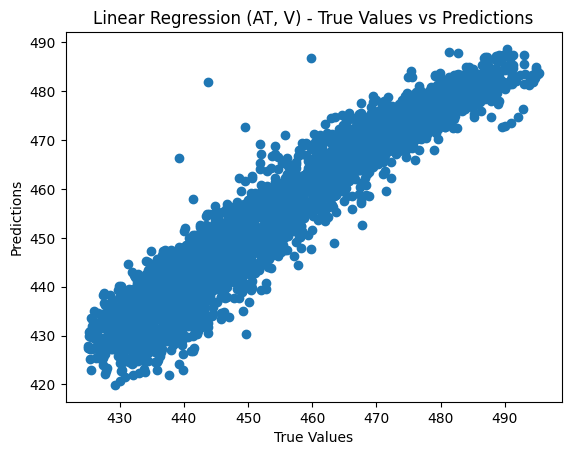

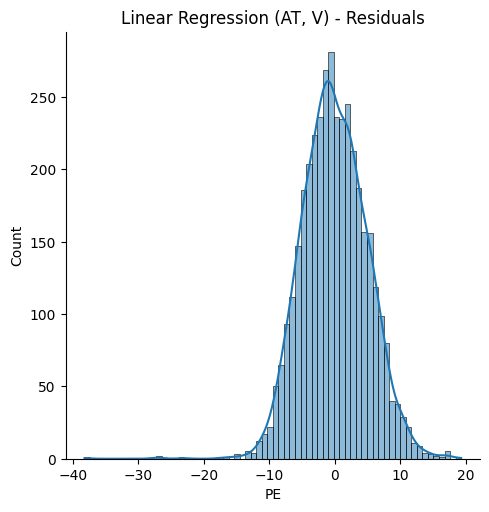

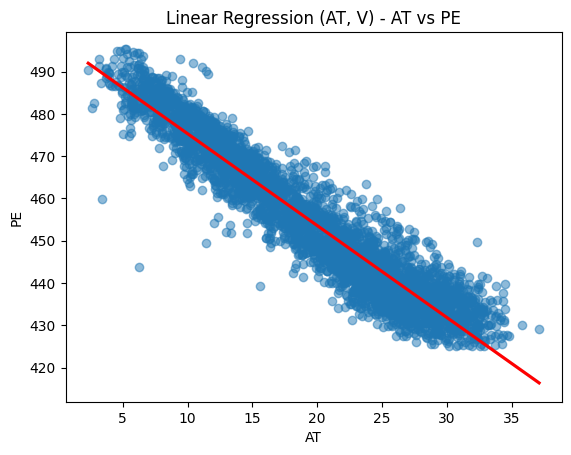

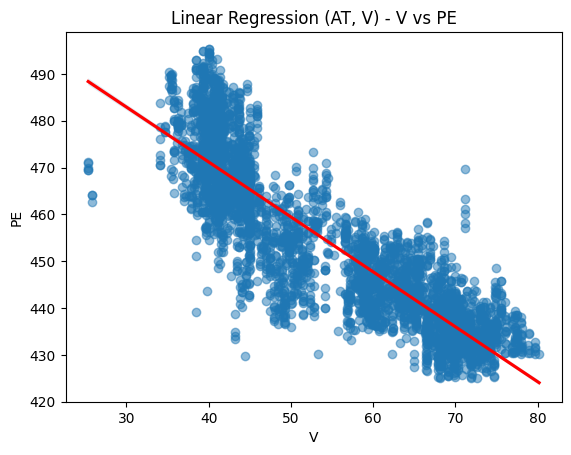

Mean squared error: 24.33
Root mean squared error: 4.93
R2: 0.92


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('model', LinearRegression())])

In [239]:
# linear regression using make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler

# all features
x_labels = ["AT", "V"]
y_label = "PE"
title = "Linear Regression (AT, V)"

# get x set wherein we only get the required columns
x_set = df[x_labels]
y_set = df[y_label]

model = LinearRegression()
pipeline = make_pipeline(
    StandardScaler()
)

pipeline, X_test, y_test = trainPipelineModel(pipeline, model, x_set, y_set)
coef, mean_se, root_mean_se, r2 = displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label)
stashResults(title, coef, mean_se, root_mean_se, r2)
saveModel(pipeline, "linear_regression_AT_V.pkl")
modelSanityCheck("linear_regression_AT_V.pkl", X_test, y_test)

### AT, V, RH only

Coefficients: 


 [-15.03887686  -2.88324185  -2.4580309 ]
Mean squared error: 20.78
Root mean squared error: 4.56
R2: 0.93


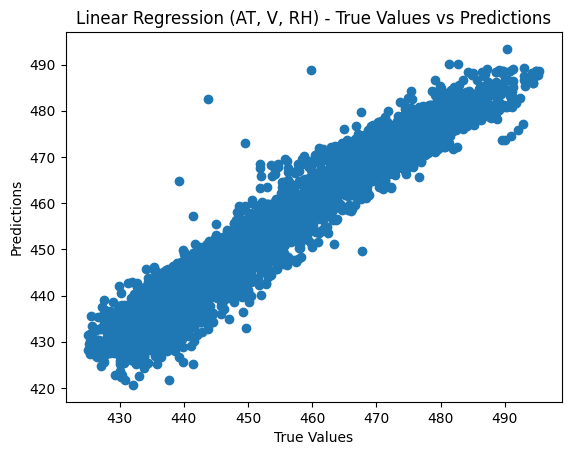

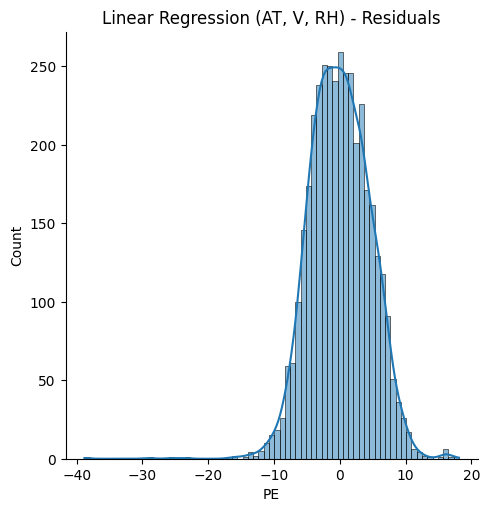

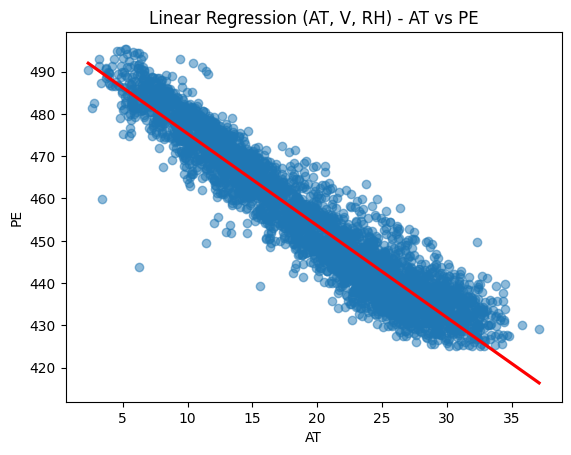

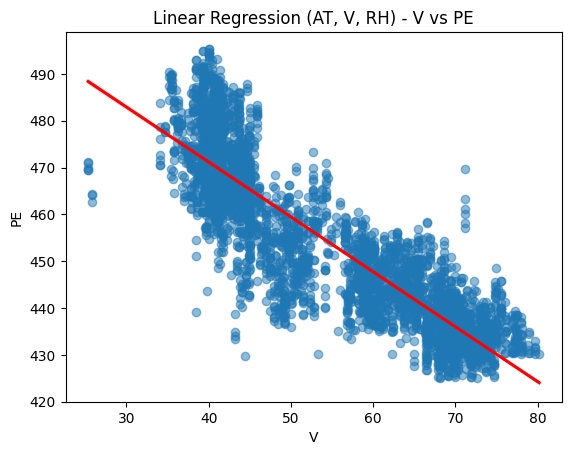

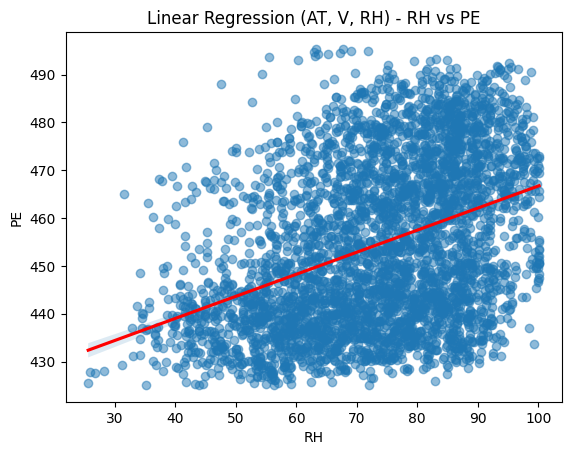

Mean squared error: 20.78
Root mean squared error: 4.56
R2: 0.93


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('model', LinearRegression())])

In [240]:
# linear regression using make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler

# all features
x_labels = ["AT", "V", "RH"]
y_label = "PE"
title = "Linear Regression (AT, V, RH)"

# get x set wherein we only get the required columns
x_set = df[x_labels]
y_set = df[y_label]

model = LinearRegression()
pipeline = make_pipeline(
    StandardScaler()
)

pipeline, X_test, y_test = trainPipelineModel(pipeline, model, x_set, y_set)
coef, mean_se, root_mean_se, r2 = displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label)
stashResults(title, coef, mean_se, root_mean_se, r2)
saveModel(pipeline, "linear_regression_AT_V_RH.pkl")
modelSanityCheck("linear_regression_AT_V_RH.pkl", X_test, y_test)

### AT, V, AP

Coefficients: 
 [-12.16568175  -4.19637841   0.84487145]
Mean squared error: 23.51
Root mean squared error: 4.85
R2: 0.92


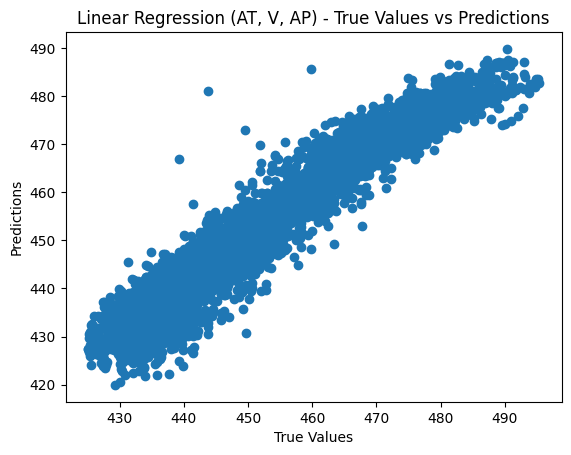

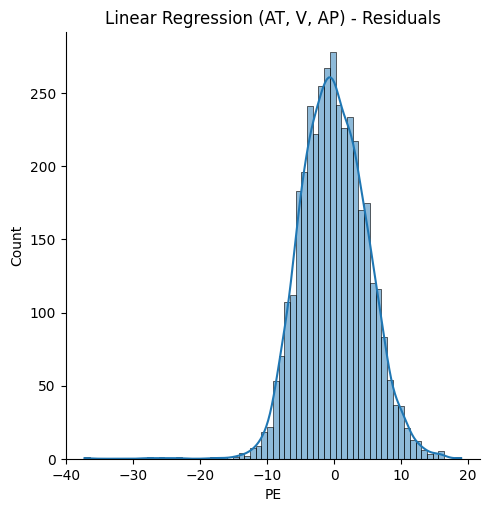

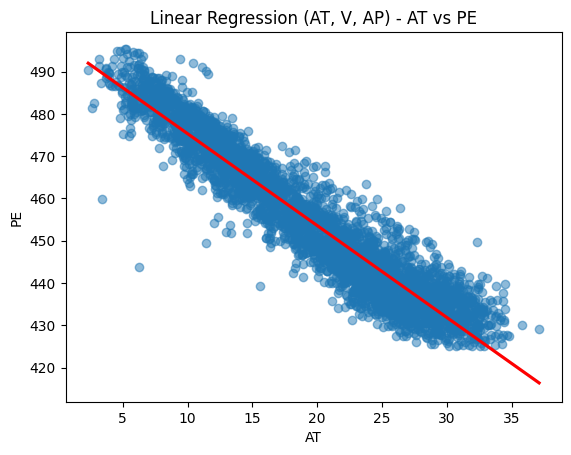

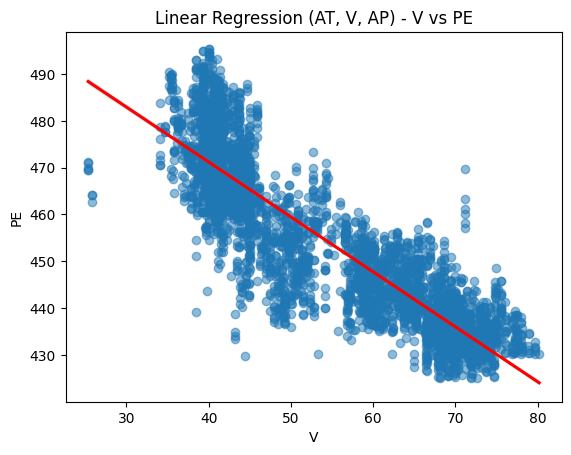

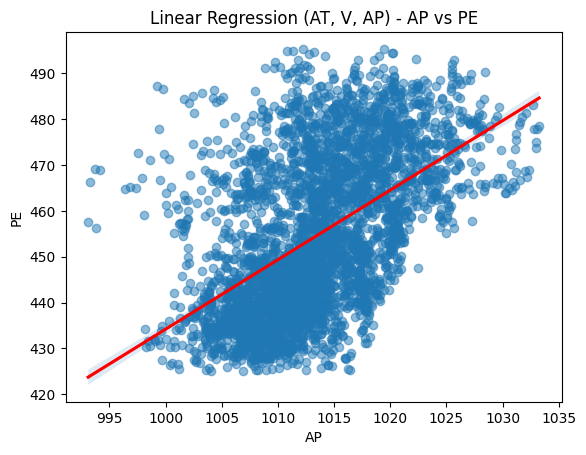

Mean squared error: 23.51
Root mean squared error: 4.85
R2: 0.92


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('model', LinearRegression())])

In [241]:
# linear regression using make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler

# all features
x_labels = ["AT", "V", "AP"]
y_label = "PE"
title = "Linear Regression (AT, V, AP)"

# get x set wherein we only get the required columns
x_set = df[x_labels]
y_set = df[y_label]

model = LinearRegression()
pipeline = make_pipeline(
    StandardScaler()
)

pipeline, X_test, y_test = trainPipelineModel(pipeline, model, x_set, y_set)
coef, mean_se, root_mean_se, r2 = displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label)
stashResults(title, coef, mean_se, root_mean_se, r2)
saveModel(pipeline, "linear_regression_AT_V_AP.pkl")
modelSanityCheck("linear_regression_AT_V_AP.pkl", X_test, y_test)   

### V, AP, RH

Coefficients: 
 [-12.71990183   3.23930581   2.34893651]
Mean squared error: 55.99
Root mean squared error: 7.48
R2: 0.81


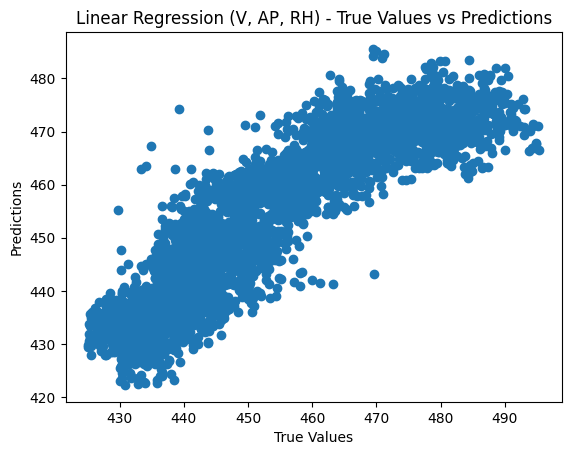

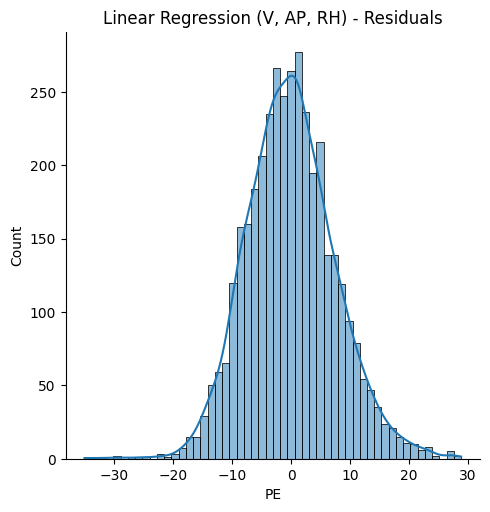

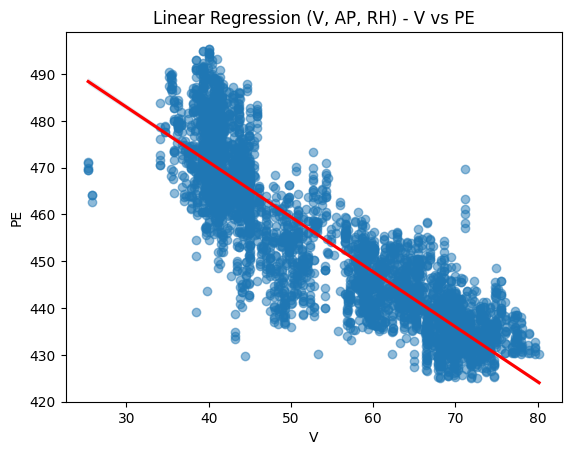

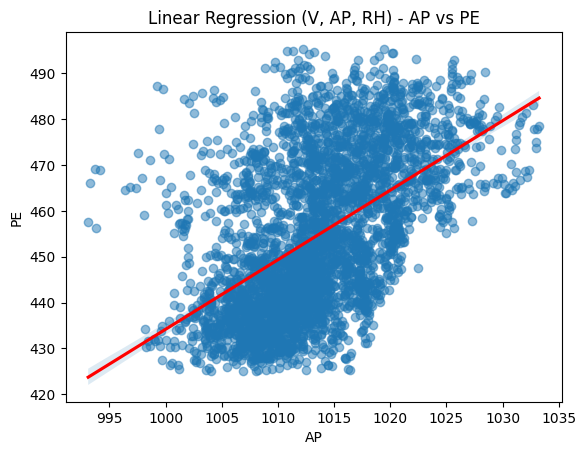

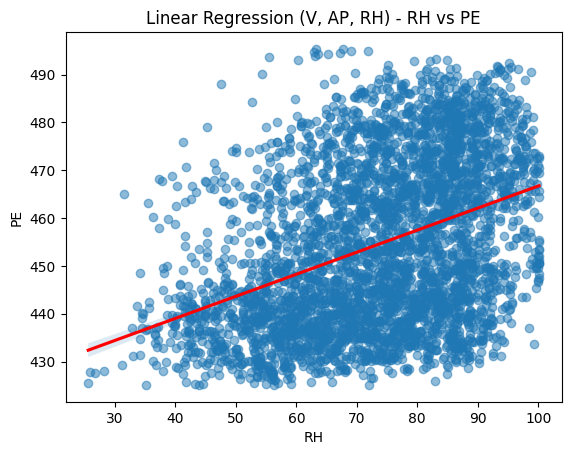

Mean squared error: 55.99
Root mean squared error: 7.48
R2: 0.81


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('model', LinearRegression())])

In [242]:
# linear regression using make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler

# all features
x_labels = ["V", "AP", "RH"]
y_label = "PE"
title = "Linear Regression (V, AP, RH)"

# get x set wherein we only get the required columns
x_set = df[x_labels]
y_set = df[y_label]

model = LinearRegression()
pipeline = make_pipeline(
    StandardScaler()
)

pipeline, X_test, y_test = trainPipelineModel(pipeline, model, x_set, y_set)
coef, mean_se, root_mean_se, r2 = displayMetrics(pipeline, X_test, y_test, title, x_labels, y_label)
stashResults(title, coef, mean_se, root_mean_se, r2)
saveModel(pipeline, "linear_regression_V_AP_RH.pkl")
modelSanityCheck("linear_regression_V_AP_RH.pkl", X_test, y_test)

## Comparing Results

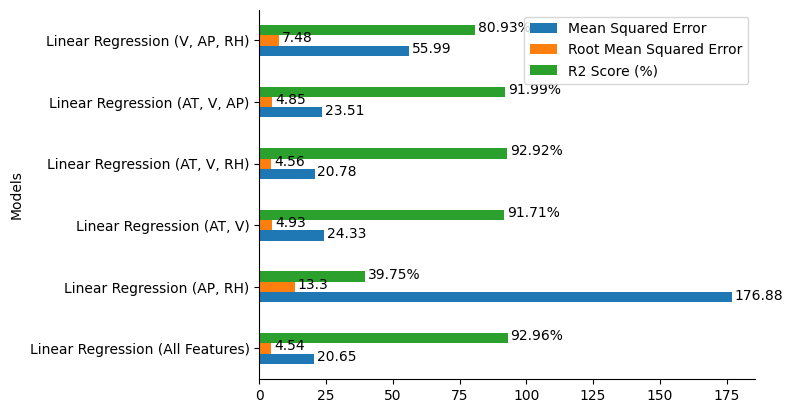

In [243]:
import pandas as pd

df = pd.DataFrame(results)
df.plot(x='title', y=['mean_se', 'root_mean_se', 'r2_percentage'], kind='barh', ylabel="Models")
# change legend
plt.legend(["Mean Squared Error", "Root Mean Squared Error", "R2 Score (%)"], loc='upper right')
# add bar text
for i in range(len(df)):
  plt.text(df['mean_se'][i] + 1, i - 0.2, round(df['mean_se'][i], 2))
  plt.text(df['root_mean_se'][i] + 1, i - 0.025, round(df['root_mean_se'][i], 2))
  plt.text(df['r2_percentage'][i] + 1, i + 0.14, f"{round(df['r2_percentage'][i], 2)}%")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()